# Parameter study for 10-armed bandit

Exercise 2.9 (programming) Make a figure analogous to Figure 2.6 for the non-stationary case outlined
in Exercise 2.5. Include the constant-step-size ε-greedy algorithm with α = 0.1. Use runs of 200,000
steps and, as a performance measure for each algorithm and parameter setting, use the average reward
over the last 100,000 steps.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class MultiArmedBandit():
    
    def __init__(self):
        self._means = np.zeros(10)
        
    def pull_arm(self, arm):
        reward = np.random.randn() + self._means[arm]
        self._means += 0.1 * np.random.randn(10)
        return reward

In [3]:
class GradientBandit():
    
    def __init__(self, learning_rate):
        self._preferences = np.zeros(10)
        self._probs = 0.1 * np.ones(10)
        self._average_reward = 0
        self._learning_rate = learning_rate
        
    def compute_action(self):
        action = np.random.choice(range(10), p=self._probs)
        return action
    
    def update_parameters(self, action, reward):
        self._update_average_reward(reward)
        self._update_preferences(action, reward)
        self._update_probabilities()
        
    def _update_preferences(self, action, reward): 
        for i in range(10):
            if i == action:
                self._preferences[i] += self._learning_rate * (reward - self._average_reward) * (1 - self._probs[i])
            else:
                self._preferences[i] -= self._learning_rate * (reward - self._average_reward) * self._probs[i]
    
    def _update_probabilities(self):
        exp_pref = np.exp(self._preferences)
        self._probs = exp_pref / np.sum(exp_pref)
        
    def _update_average_reward(self, reward):
        self._average_reward += 0.1 * (reward-self._average_reward)

In [4]:
class UCB():
    
    def __init__(self, c):
        self._c = c
        self._selection_cnt = np.ones(10)
        self._action_values = np.zeros(10)
        
    def compute_action(self):
        t = np.sum(self._selection_cnt)
        upper_confidence_bounds = self._action_values + self._c * np.sqrt(t / self._selection_cnt)
        return np.argmax(upper_confidence_bounds)
    
    def update_parameters(self, action, reward):
        self._action_values[action] += 0.1 * (reward - self._action_values[action])

In [11]:
class GreedyOptimisticInitialValues():
    
    def __init__(self, initial_values):
        self._action_values = initial_values * np.ones(10)
        
    def compute_action(self):
        return np.argmax(self._action_values)
    
    def update_parameters(self, action, reward):
        self._action_values[action] += 0.1 * (reward - self._action_values[action])

In [6]:
class EpsilonGreedy():
    
    def __init__(self, epsilon):
        self._epsilon = epsilon
        self._action_values = np.zeros(10)
        
    def compute_action(self):
        if np.random.rand() < self._epsilon:
            return np.random.randint(10)
        else:
            return np.argmax(self._action_values)
        
    def update_parameters(self, action, reward):
        self._action_values[action] += 0.1 * (reward - self._action_values[action])

In [20]:
def compute_average_reward(algorithm, timesteps, param = None):
    rewards = np.zeros((2000, timesteps))
    for i in range(2000):
        mab = MultiArmedBandit()
        if param:
            alg = algorithm(param)
        else:
            alg = algorithm()
        for j in range(timesteps):
            action = alg.compute_action()
            reward = mab.pull_arm(action)
            rewards[i,j] = reward
            alg.update_parameters(action, reward)
    mean_rewards = np.mean(rewards, axis=0)
    return np.mean(mean_rewards[timesteps//2:])

In [21]:
def meta_compute_average_rewards(algorithm, timesteps, params):
    n = len(params)
    average_rewards = np.zeros(n)
    for idx, value in enumerate(params):
        average_rewards[idx] = compute_average_reward(algorithm, timesteps, param=value)
    return average_rewards

In [32]:
timesteps = 2000

ucb_params = [2**i for i in range(-8,7)]
ucb_rewards = meta_compute_average_rewards(UCB, timesteps, ucb_params)

gradient_params = [2**i for i in range(-9,1)]
gradient_rewards = meta_compute_average_rewards(GradientBandit, timesteps, gradient_params)

epsgreedy_params = [2**i for i in range(-7,-1)]
epsgreedy_rewards = meta_compute_average_rewards(EpsilonGreedy, timesteps, epsgreedy_params)

greedy_params = [2**i for i in range(-2,8)]
greedy_rewards = meta_compute_average_rewards(GreedyOptimisticInitialValues, timesteps, greedy_params)

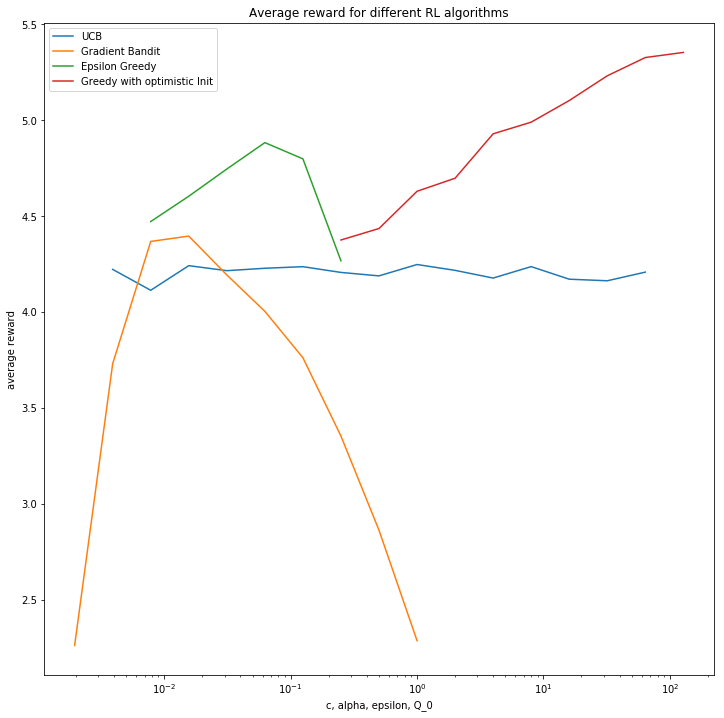

In [33]:
fig = plt.figure(figsize=(12,12))
plt.semilogx(ucb_params, ucb_rewards)
plt.semilogx(gradient_params, gradient_rewards)
plt.semilogx(epsgreedy_params, epsgreedy_rewards)
plt.semilogx(greedy_params, greedy_rewards)
plt.xlabel('c, alpha, epsilon, Q_0')
plt.ylabel('average reward')
plt.title('Average reward for different RL algorithms')
plt.legend(['UCB', 'Gradient Bandit', 'Epsilon Greedy', 'Greedy with optimistic Init'])